In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
import general_utils.utils as utils
from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap, get_froc_df_of_img, get_froc_df_of_many_imgs_features
from mc_candidate_proposal.candidate_utils import balance_candidates

cmap = plt.get_cmap("tab10")

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train', 'validation'],  # This is not working as you want since last update, to do so include validation
        extract_patches=True,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

# Settings

In [5]:
CENTER_CROP_PATCH = 7
PATCH_SIZE = 30

hd = HoughCalcificationDetection()

# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': [], 'feature_coord': []
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}

cfe = CandidatesFeatureExtraction(patch_size=PATCH_SIZE, fos=False, haar_params=haar_params)

# Example of how to train / validate a model with my changes
# (using feature arrays of all candidates)

100%|██████████| 154/154 [07:37<00:00,  2.97s/it]


Auc test: 0.949213838294348


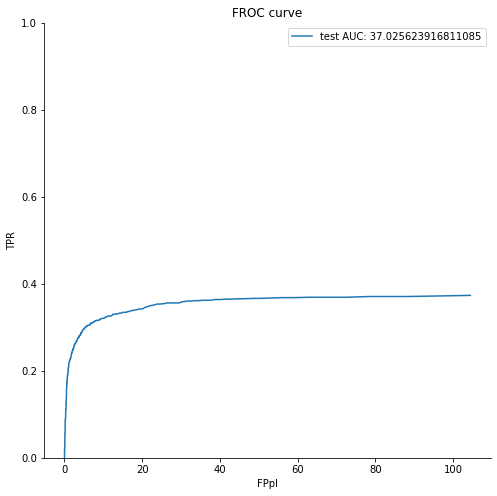

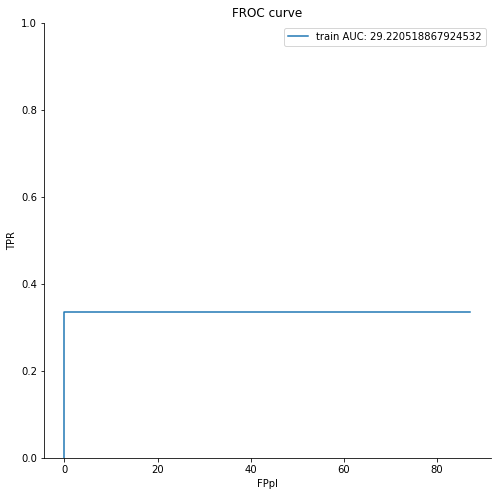

In [4]:
test_img_id = db.df.img_id.unique()[:50] 
fdf = []
fns_df = []
for idx in tqdm(range(len(db))):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    image_mask = db_sample['lesion_mask']

    # candidate detection
    candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

    # labeling of candidates:
    tp, fp, fn = utils.get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)

    # Balancing the candidates
    tp, fp = balance_candidates(tp, fp, fp2tp_sample=10)

    # Extracting features
    candidates = tp + fp
    labels = np.array([True] * len(tp) + [False] * len(fp))
    
    X = cfe.extract_features(np.asarray(candidates), image)

    # Get features dfs
    res = pd.DataFrame(data=X, columns=cfe.feature_names)
    res['labels'] = labels
    res['img_id'] = image_id

    # Generate a fn dataframe to compute frocs
    fn_df = pd.DataFrame(fn, columns=['x', 'y', 'radius'])
    fn_df['labels'] = 'FN'
    fn_df['img_id'] = image_id
    fns_df.append(fn_df)

    fdf.append(res)

data = pd.concat(fdf, ignore_index=True)
fns_df = pd.concat(fns_df, ignore_index=True)

# Divide train and test based on cases (cross validation image wise)
train_df = data[~data.img_id.isin(test_img_id)]
train_fns_df = fns_df[~fns_df.img_id.isin(test_img_id)]
test_df = data[data.img_id.isin(test_img_id)]
test_fns_df = fns_df[fns_df.img_id.isin(test_img_id)]

# Generate features and labels datasets
train_X = train_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
train_y = (train_df.labels).astype(int)
test_X = test_df.drop(columns=['patch_coordinates', 'candidate_coordinates', 'labels', 'img_id'])
test_y = (test_df.labels).astype(int)

#Train a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, n_jobs=-1, random_state=0)
clf.fit(train_X, train_y)

# Store the trained models
path = (Path.cwd().parent.parent / 'data')
filename = f'test_roc_clf.sav'
pickle.dump(clf, open(path / filename, 'wb'))

# Asses performance
test_y_predicted = clf.predict_proba(test_X)[:, 1]
train_y_predicted = clf.predict_proba(train_X)[:, 1]

auc_test = roc_auc_score(test_y, test_y_predicted)

print(f'Auc test: {auc_test}')

froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'labels', 'img_id']],
    test_fns_df,
    test_y_predicted
)

froc_df_train = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'labels', 'img_id']],
    train_fns_df,
    train_y_predicted
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df)
plot_froc(avgs_fp_per_image, sens, label='test')
sens, avgs_fp_per_image, _ = froc_curve(froc_df_train)
plot_froc(avgs_fp_per_image, sens, label='train')

# avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30)
# plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities)

# Example of how to test image by image a model with my changes

100%|██████████| 154/154 [03:01<00:00,  1.18s/it]


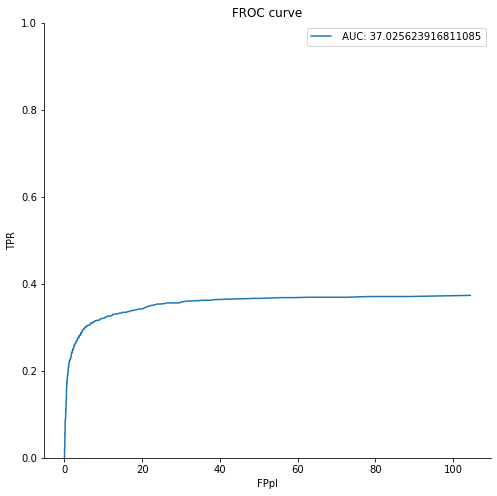

100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


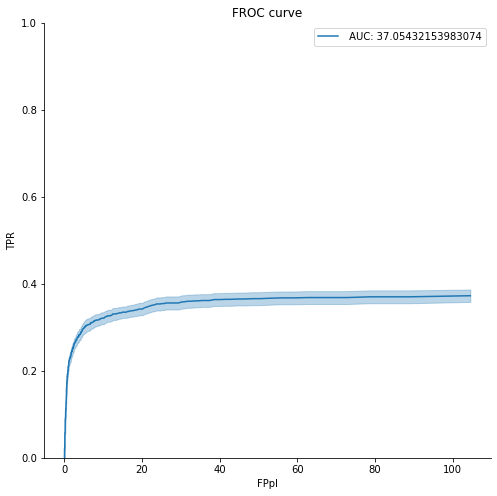

In [6]:
# Save the model to disk
test_img_id = db.df.img_id.unique()[:50]
path = (Path.cwd().parent.parent / 'data')
filename = f'test_roc_clf.sav'
clf = pickle.load(open(path / filename, 'rb'))

froc_dfs = []
for idx in tqdm(range(len(db))):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db_sample['img_id']
    if image_id not in test_img_id:
        continue
    
    image_mask = db_sample['lesion_mask']

    # candidate detection
    candidates = hd.detect(image, image_id, load_processed_images=True, hough2=False)[0]

    # labeling of candidates:
    tp, fp, fn = utils.get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, CENTER_CROP_PATCH, PATCH_SIZE)

    # Balancing the candidates
    tp, fp = balance_candidates(tp, fp, fp2tp_sample=10)

    # Extracting features
    candidates = tp + fp
    labels = np.array([True] * len(tp) + [False] * len(fp))
    
    X = cfe.extract_features(np.asarray(candidates), image)
    
    predictions = clf.predict_proba(X[:,:-2])[:, 1]
    
    froc_df = get_froc_df_of_img(tp, fp, fn, predictions, image_id)
    froc_dfs.append(froc_df)

froc_df = pd.concat(froc_dfs, ignore_index=True)

sens, avgs_fp_per_image, _ = froc_curve(froc_df)
plot_froc(avgs_fp_per_image, sens)

avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30)
plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities)